# Análisis de actividad sísmica en México

![Alerta](im.png)

Para los que tengan curiosidad de ver cómo se sacó la información de la página del SSN, hay otro .ipynb en este folder donde se explica detalladamente. Lo primero que hay que hacer es cargar los paquetes necesarios. Esto significa importar (e instalar anteriormente) los siguientes paquetes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import seaborn as sns
import folium

from helpers.Mexico import Republica

republica = Republica()

sns.set_style("darkgrid")

El paquete de seaborn lo pueden instalar con pip3, al igual que folium. helpers.Mexico es un paquete que yo hice para ayudarles un poco, de ahí saco la clase `Republica`.

De los paquetes necesarios, `Folium` es por mucho el más complejo. Permite hacer mapas interactivos en jupyter. Yo me he dado a la tarea de bajar del inegi las divisiones políticas del país y pasarlas a un formato que `Folium` entiende, conocido como topojson. El archivo se encuentra en el folder `helpers`. No es necesario que entiendan su contenido, pero yo les explicaré más adelante su uso.

Carguemos rápidamente el csv de la actividad sísmica reportada por el SSN de la UNAM desde el 1 de Enero de 1990 hasta el 17 de Febrero del 2018. Además de cargar el csv, vamos a ver los primeros 5 renglones, para familiarizarnos con el formato:

In [3]:
#Definimos una lambda que convierta una cadena de caracteres en una etiqueta de tiempo.
mConverters = {'Fecha y Hora': lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') }
#Usamos la lambda para cargar el csv. Los nombres de las columnas son el primer renglón
sismos = pd.read_csv('helpers/earthquakes.csv', index_col = 0, converters = mConverters)
#Mostremos los primeros 5 renglones con la función head
sismos.head()

,Magnitud,Latitud,Longitud,Profundidad (km),Fecha y Hora
0,3.2,15.83,-98.41,17,2018-02-17 23:57:31
1,2.8,16.28,-98.08,12,2018-02-17 23:56:51
2,3.1,16.21,-98.02,10,2018-02-17 23:53:03
3,2.8,16.03,-97.75,16,2018-02-17 23:52:22
4,4.1,32.64,-115.18,4,2018-02-17 23:49:44


El csv es muy, muy sencillo. Contiene sólo 5 columnas: Magnitud, Latitud, Longitud, Profundidad y Fecha-Hora. Las primeras tres columnas son flotantes, mientras la quinta es una estampa de tiempo. Tendrán que aprender a usar estampas de tiempo pero yo les puedo ayudar.

## Ejercicio 1: Magnitud de los sismos

Calculen las siguientes cantidades (explicando en su código cómo lo hacen):
1. Cuenta total de sismos
2. Rango de magnitud de los sismos
3. Número de sismos por cada categoría, siendo las categorías {[1,2), [2,3),[3,4),[4,5),[5,6),[6,7),[7,8),[8,9)}
3. Número de sismos en cada año, graficado como un histograma (¿Ha aumentado la actividad sísmica?)

In [4]:
'Cuenta total de sismos: {}'.format(len(sismos))

'Cuenta total de sismos: 105946'

In [5]:
# Rango de magnitud de sismos:

'El rango de los sismos registrados entre 1990 a 2018 es [{}, {}]'.format(sismos['Magnitud'].min(),
                                                                          sismos['Magnitud'].max())

'El rango de los sismos registrados entre 1990 a 2018 es [1.2, 8.2]'

In [6]:
for i in range(1,9):
    res = sismos[(sismos.Magnitud >=i) & (sismos.Magnitud < (i + 1))].count()
    print('Número de sismos en rango [{0}, {1}): {2}'.format(i, i+1, res.Magnitud))

Número de sismos en rango [1, 2): 54
Número de sismos en rango [2, 3): 1961
Número de sismos en rango [3, 4): 79319
Número de sismos en rango [4, 5): 23613
Número de sismos en rango [5, 6): 883
Número de sismos en rango [6, 7): 98
Número de sismos en rango [7, 8): 16
Número de sismos en rango [8, 9): 2


<IPython.core.display.Javascript object>


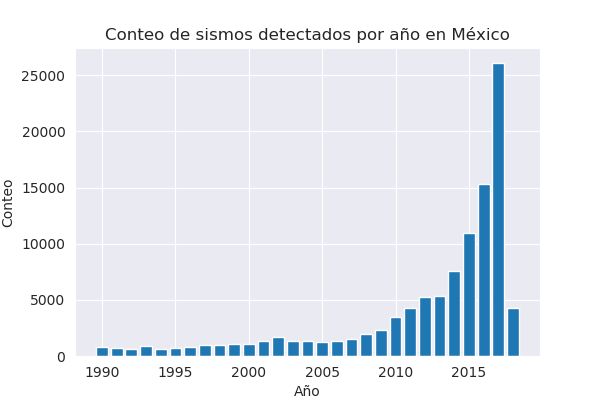

In [9]:
%matplotlib notebook

conteo_año = sismos.groupby(sismos['Fecha y Hora'].dt.year).count()
conteo_año = conteo_año['Magnitud']

fig = plt.figure(figsize=(6, 4))
bars = plt.bar(conteo_año.index, conteo_año);
ax = fig.gca();
ax.set_ylabel('Conteo');
ax.set_xlabel('Año');
ax.set_title('Conteo de sismos detectados por año en México');

## Ejercicio 2: Graficando en el mapa

Para lo que viene, ustedes deben añadir una columna de nombre "Estado" al DataFrame `sismos`. Para ello, la variable `republica` declarada al principio del documento tiene una función llamada `estadoSegunPunto` que recibe como parámetros un par de números (latitud y longitud) y dice en qué estado de la república ocurrió el sismo (por ejemplo `republica.estadoSegunPunto(19,-100)`. La función devuelve `np.nan` si el punto no se encuentra dentro de un estado. Como ejercicio:

1. Calculen el porcentaje de epicentros dentro del territorio mexicano (en este caso el mar no cuenta).
2. Calculen cuántos sismos ocurrieron por estado.
3. Determinen cual es el estado con menor actividad sísmica (en cuanto a epicentros) y cuál el de mayor
4. Hagan un mapa de colores de la actividad sísmica por estado. Agarren buenos colores y usen una buena escala.

Para el cuarto punto, utilicen `Folium`. Les dejo el tip: las funciones que necesitan son `folium.Map()` (que genera un objeto, llamémoslo `mexmap`) y la función `.choropleth` (miembro de `mexmap`). Hay ejemplos en internet de esto, pero si tienen dudas y están muy muy frustrados, mándenme un correo y les ayudo un poco. Para generar el _choropleth_, necesitan el archivo `helpers/mexican_states.geojson`, la función `choropleth` se los va a pedir pero no tienen que entender lo que hay dentro. Ah, eso sí, los nombres de los estados están etiquetados por el nombre "NOM_ENT" (`choropleth` se los va a pedir...).

In [10]:
sismos['Lugar'] = sismos.apply(lambda x: republica.estadoSegunPunto(x['Latitud'], x['Longitud']), axis=1)

In [11]:
'Porcentaje de sismos en el territorio nacional: {}%'.format(sismos['Lugar'].count()*100/len(sismos))

'Porcentaje de sismos en el territorio nacional: 43.97051328035037%'

In [12]:
print('El número de sismos ocurridos en cada estado es:')
conteo_estados = sismos['Lugar'].value_counts();
conteo_estados = conteo_estados.to_frame().reset_index()
conteo_estados = conteo_estados.rename(index=str, columns={"index": "Estado", "Lugar": "Conteo"})
conteo_estados

El número de sismos ocurridos en cada estado es:


,Estado,Conteo
0,Oaxaca,23615
1,Guerrero,11732
2,Chiapas,3387
3,Veracruz de Ignacio de la Llave,2415
4,Michoacán de Ocampo,1628
5,Jalisco,1269
6,Puebla,556
7,Nuevo León,355
8,Chihuahua,340
9,Hidalgo,329


In [13]:
print('El estado con mayor número de epicentros contados es: {}'.format(sismos['Lugar'].value_counts().idxmax()))
print('El estado con menor número de epicentros contados es: {}'.format(sismos['Lugar'].value_counts().idxmin()))

El estado con mayor número de epicentros contados es: Oaxaca
El estado con menor número de epicentros contados es: Campeche


In [16]:
m = folium.Map([24,-100], zoom_start=5)

m.choropleth(
    geo_data='helpers/mexican_states.geojson',
    data=conteo_estados,
    columns=['Estado', 'Conteo'],
    key_on='feature.properties.NOM_ENT',
    fill_color='YlOrRd')
m

## Ejercicio 3: Terremotos

En este bloque:
1. Calculen cuántos sismos de magnitud igual o mayor a 6.8 han ocurrido en los últimos 28 años
2. Saquen la distancia temporal entre ellos, calculen su media y la desviación estándar (¿Algún patrón?)
3. Verifiquen, con el coeficiente de correlación, si hay dependencia entre magnitud y profundidad de los terremotos
4. **Colóquenlos en el mapa, de manera proporcional a la energía que liberaron** (un poco de ayuda después)

La tarea de graficar esto no es tan sencilla, por fortuna seguimos utilizando `folium`.

Para el 4to punto, necesito que hagan algo muy específico: La escala de Richter es una escala logaritmica de base 10, donde la magnitud $M_L$ se determina como.

$M_L = log_{10}\left(\frac{A}{A(\delta)}\right)$

siendo $A$ la amplitud registrada por un sismografo, y $A(\delta)$ una función de amplitud de referencia con una compensación basada en la distanca del sismógrafo al epicentro del sismo $\delta$. La relación de energía con la amplitud de una onda sismicaa es $E \propto A^{3/2}$. Esto quiere decir que un sismo de 5 grados libera $\approx 31.6$ veces menos energía que un sismo de 6 grados. Para graficar la localización y cantidad de energía liberada por estos sismos, hagan uso de la función "CircleMarker" de folium, y hagan una selección **adecuada** (en verdad enfatizo eso) del radio de los marcadores, sabiendo que lo que se busca es que los círculos representen la cantidad de energía liberada.

Además les dejo una función que hace un gradiente lineal de color entre dos tripletes RGB (red green blue) entre dos escalas de sismos (por defecto, 6.8 un extremo y 8.2 el otro). La pueden utilizar para darle color a los círculos también (pueden modificar la función para usar los colores que quieran)

In [17]:
def intensityColor(intensity, minVal = 6.8, maxVal = 8.2):
    minimumColor, maximumColor = np.array([32, 193, 116]), np.array([243, 40, 40]) #par de tripletes RGB
    #Garantiza que el número está en el rango
    intensity = maxVal if intensity > maxVal else intensity
    intensity = minVal if intensity < minVal else intensity
    #Parametriza al intervalo 0,1
    intensity = (intensity - minVal) / (maxVal-minVal)
    #Asigna color linealmente
    currentColor = np.floor(maximumColor*(intensity) + minimumColor * (1 - intensity)).astype(int)
    #Regresa el color en formato hexadecimal, el cual CircleMarker entiende
    return '#%02x%02x%02x' % tuple(currentColor)

In [18]:
'El número de sismos con intensidad mayor a 6.8 es: {}'.format(sismos[sismos.Magnitud > 6.8].count()['Magnitud'])

'El número de sismos con intensidad mayor a 6.8 es: 20'

In [19]:
sismos_fuertes = sismos[sismos.Magnitud > 6.8]
print('La distancia temporal entre sismos de magnitud mayor a 6.8 es:')
sismos_fuertes['Fecha y Hora'].iloc[::-1].diff(periods=1)

La distancia temporal entre sismos de magnitud mayor a 6.8 es:


103275                  NaT
101987    733 days 18:51:36
101838     25 days 01:31:21
101763     11 days 11:03:04
101525    127 days 00:29:21
100789    321 days 17:20:07
100484    109 days 16:09:10
98310     775 days 09:04:28
97990     106 days 19:49:09
97008     313 days 19:10:34
93522     895 days 13:24:47
81966    2629 days 21:34:08
73928     715 days 18:22:06
70545     231 days 22:33:02
62645     526 days 22:51:31
60970      79 days 20:56:38
23934    1072 days 20:05:04
19741      85 days 21:20:15
16699      11 days 13:25:22
524       150 days 04:24:58
Name: Fecha y Hora, dtype: timedelta64[ns]

In [20]:
print('Media temporal de la separación: {}'.format(sismos_fuertes['Fecha y Hora'].iloc[::-1].diff(periods=1).mean()))
print('Desviación estándar temporal de la separación: {}'.format(sismos_fuertes['Fecha y Hora'].iloc[::-1].diff(periods=1).std()))
print('Media magnitud de sismos fuertes: {}'.format(sismos_fuertes['Magnitud'].mean()))
print('Desviación estándar de sismos fuertes: {}'.format(sismos_fuertes['Magnitud'].std()))

Media temporal de la separación: 469 days 17:55:05.315789
Desviación estándar temporal de la separación: 620 days 21:16:23.997631
Media magnitud de sismos fuertes: 7.264999999999999
Desviación estándar de sismos fuertes: 0.3407036063331601


In [21]:
print('La correlación para sismos fuertes entre profundidad y magnitud es: {}'.format(sismos_fuertes['Profundidad (km)'].corr(sismos_fuertes['Magnitud'])))
print('La correlación para todos los sismos entre profundidad y magnitud es: {}'.format(sismos['Profundidad (km)'].corr(sismos['Magnitud'])))

La correlación para sismos fuertes entre profundidad y magnitud es: -0.16194437208911105
La correlación para todos los sismos entre profundidad y magnitud es: 0.12929343367499696


In [22]:
m_1 = folium.Map([24,-100], zoom_start=5)

for i in range(0, len(sismos_fuertes)):
    folium.CircleMarker([sismos_fuertes.iloc[i]['Latitud'], sismos_fuertes.iloc[i]['Longitud']],
                        radius=10*(sismos_fuertes.iloc[i]['Magnitud'] - 6.8) / (8.2 - 6.8),
                        popup='Magnitud: {}, Fecha: {}'.format(sismos_fuertes.iloc[i]['Magnitud'], 
                                                              sismos_fuertes.iloc[i]['Fecha y Hora'].strftime('%m/%d/%Y')),
                        color=intensityColor(sismos_fuertes.iloc[i]['Magnitud']),
                        fill=True,
                        fill_color=intensityColor(sismos_fuertes.iloc[i]['Magnitud']),
                        fill_opacity=0.5).add_to(m_1)
m_1

## Ejercicio 4: Buscando patrones antes de un evento de gran escala (medio difícil)

En la siguiente parte, vamos a ver si, de manera sencilla, podemos encontrar patrones de comportamiento sísmico antes de un evento de gran escala (Terremoto de magnitud >= 7.0). Como primer ejercicio, encuentre cuántos sismos hay con dicha magnitud:

1. Definan un intervalo de tiempo a analizar antes de un sismo de gran magnitud, por ejemplo, 24 horas ó 5 días (justifiquen su escala de tiempo)
2. Para todos los sismos de magnitud igual o mayor a 7.0, grafiquen el comportamiento de la región (en un ángulo sólido prudente) en el periodo de tiempo que escogieron antes del sismo. Busquen si hay algún patrón evidente y concluyan.

Como tip, la diferencia de dos estampas de tiempo genera un pd.Timedelta. La siguiente función puede tomar un arreglo ( o una serie) de `pd.Timedelta` para convertirlo en horas:

In [23]:
toHours = np.vectorize(lambda x : x.total_seconds()/3600)

Les va a ser mucho más fácil si trabajan en horas para este ejercicio.

In [24]:
sismos_mas_fuertes = sismos[sismos.Magnitud > 7.0]
print('El número de sismos con magnitud mayor a 7.0 es: {}'.format(len(sismos_mas_fuertes)))

El número de sismos con magnitud mayor a 7.0 es: 15


In [25]:
dic_gen={}

for i in range(0, len(sismos_mas_fuertes)):
    dfecha = sismos_mas_fuertes.iloc[i]['Fecha y Hora']
    dmagnitud = sismos_mas_fuertes.iloc[i]['Magnitud']
    dlatitud = sismos_mas_fuertes.iloc[i]['Latitud']
    dlongitud = sismos_mas_fuertes.iloc[i]['Longitud']
    sub_sismos = sismos[sismos['Fecha y Hora'].map(lambda d: (d <= dfecha and d > (dfecha - pd.Timedelta('7 days'))))]
    sub_sismos = sub_sismos[sub_sismos['Longitud'].map(lambda d: (d < (dlongitud+2) and d > (dlongitud-2)))]
    sub_sismos = sub_sismos[sub_sismos['Latitud'].map(lambda d: (d < (dlatitud+1) and d > (dlatitud-1)))]
    dic_gen["{0}, {1}".format(dmagnitud, dfecha.strftime('%m/%d/%Y'))] = sub_sismos

Arriba están los datos en un diccionario, yo seleccioné los eventos en un rangeo de 7 días previos al sismos de
mayor magnitud, así mismo mi rango de latitud y longitud fue de 2$^{\circ}$ y 4$^{\circ}$ alrededor del epicentro
del evento. La verdad no se ocurrió alguna forma divertida de presentarlos.

# Ejercicio 5: Qué más nos hace falta decir? (extra)

En esta última parte, pueden hacer **lo que quieran** con los datos. Agruparlos, clasificarlos, tienen libertad de sacar conclusiones de los datos que les he dado, pueden hacer algo con los mapas o hacer histogramas, queda en ustedes :)

In [26]:
df = sismos[sismos['Fecha y Hora'].map(lambda d: not ((d.month == 2) and (d.day == 29)))]
df15 = df[df['Fecha y Hora'] >= '2017-01-01']
df15['Fecha y Hora'] = df15['Fecha y Hora'].dt.dayofyear
df15['MagMax'] = df15.groupby(df15['Fecha y Hora'])['Magnitud'].transform('max')
df15['MagMin'] = df15.groupby(df15['Fecha y Hora'])['Magnitud'].transform('min')
df15 = (df15.drop_duplicates(subset=['Fecha y Hora', 'MagMax', 'MagMin']).sort_values(by=['Fecha y Hora'])
        .set_index('Fecha y Hora')
        .drop(['Magnitud', 'Latitud', 'Longitud', 'Lugar', 'Profundidad (km)'], axis = 1))
df15.index.names = ['Fecha']

df0514 = df[df['Fecha y Hora'] <= '2016-12-31']
df0514['Fecha y Hora'] = df0514['Fecha y Hora'].dt.dayofyear
df0514['MagMax'] = df0514.groupby(df0514['Fecha y Hora'])['Magnitud'].transform('max')
df0514['MagMin'] = df0514.groupby(df0514['Fecha y Hora'])['Magnitud'].transform('max')
df0514 = (df0514.drop_duplicates(subset=['Fecha y Hora', 'MagMax', 'MagMin']).sort_values(by=['Fecha y Hora'])
          .set_index('Fecha y Hora')
        .drop(['Magnitud', 'Latitud', 'Longitud', 'Lugar', 'Profundidad (km)'], axis = 1))
df0514.index.names = ['Fecha']
df0514 = df0514[df0514.index != 366]

/home/hadas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hadas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/hadas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [27]:
# Buscamos records.

df15Max = df15[df15['MagMax'] > df0514['MagMax']]['MagMax']

In [28]:
dt = pd.datetime(2014,12,31)
dates1 = []
for i in df0514.index:
    dates1.append(dt + pd.Timedelta('{0} days'.format(i)))

dates2 = []
for i in df15Max.index:
    dates2.append(dt + pd.Timedelta('{0} days'.format(i)))

<IPython.core.display.Javascript object>


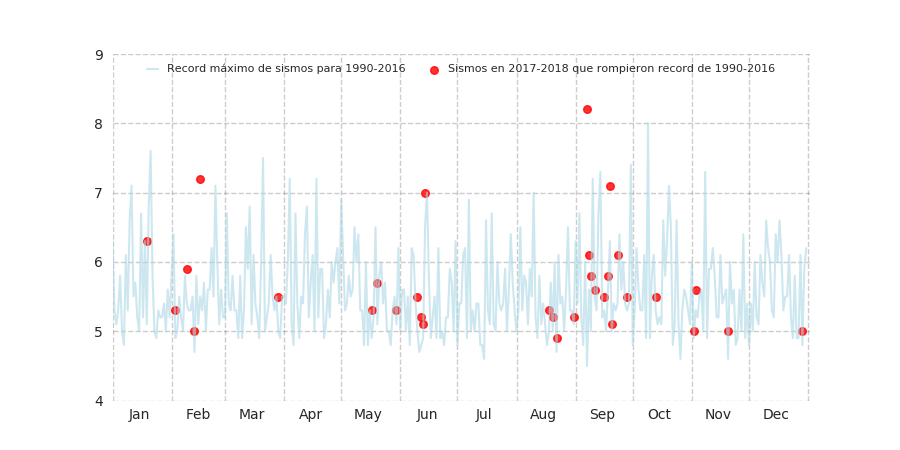

In [29]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(9, 4.5))
low = plt.plot(dates1, df0514['MagMax'], label= 'Record máximo de sismos para 1990-2016', 
               lw=1.5, alpha=0.6, color = 'lightblue')
# high = plt.plot(df0514.index, df0514['MagMin'], label= 'Record mínimo de sismos para 1990-2016', 
#                 lw=3, alpha=0.6, color = 'lightblue')
ax = plt.gca()
# shade = ax.fill_between(df0514.index, df0514['MagMin'], df0514['MagMax'], facecolor='lightgrey', alpha =0.25)
scater_high = plt.scatter(dates2, df15Max, label= 'Sismos en 2017-2018 que rompieron record de 1990-2016',
                         marker='o', color='r', s=30, alpha=0.8)

leg = plt.legend(loc='upper center', prop={'size':8}, ncol = 2, 
                 handlelength=1, scatterpoints=1, frameon = False)
leg.get_frame().set_alpha(0.)

ax.axis(['2015/01/01','2016/01/02',4.0,9.0])
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
vals = ax.get_yticks()
# ax.set_yticklabels(['{}$^{{\circ}}$C'.format(int(x/10)) for x in vals])

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

ax.grid(color='k', linestyle='--', linewidth=1, alpha = 0.2)

for spine in ax.spines.values():
    spine.set_visible(False)


Se observa que los sismos ocurridos en el año 1027 y lo que va de 2018 han superdado varios records históricos
del periodo 1990 a 2016.